In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR

from utils import convert_to_cat, one_hot_encode
from utils import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from utils import get_classification_summary, get_table_metrics, get_epsilon_plots
from utils import dp_model_classification_helper, get_dp_model_table_metrics

from kanon import convert_to_str, get_spans, partition_dataset, is_k_anonymous, build_anonymized_dataset, drop_grouped_rows

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Convert all columns to categorical

In [3]:
# Read in the original data
adult_cols = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 
              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
              'hours_week', 'native_country', 'label']
adult_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_data = pd.read_csv(adult_path, skipinitialspace=True, names=adult_cols, index_col=False)
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Get the categorical data
cat_adult = convert_to_cat(adult_data, dataset="adult")
cat_adult

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
0,0,0,0,13,0,0,0,1,0,0
1,1,1,0,13,1,1,0,1,1,0
2,0,2,1,9,2,0,0,1,0,0
3,1,2,2,7,2,1,1,1,0,0
4,2,2,0,13,3,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
32556,2,2,6,12,10,2,0,0,0,0
32557,0,2,1,9,9,1,0,1,0,1
32558,1,2,1,9,0,4,0,0,0,0
32559,3,2,1,9,0,3,0,1,1,0


In [5]:
# Get the one-hot encoded data
encoded_adult = one_hot_encode(cat_adult, dataset="adult")
encoded_adult

,sex,label,age_1,age_2,age_3,age_4,workclass_1,workclass_2,workclass_3,workclass_4,...,relationship_3,relationship_4,relationship_5,race_1,race_2,race_3,race_4,hours_week_1,hours_week_2,hours_week_3
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32557,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32558,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
32559,1,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [6]:
# Split the categorical and one-hot encoded data into train and test
cat_train, cat_test = train_test_split(cat_adult, test_size=0.2, random_state=0)
encoded_train, encoded_test = train_test_split(encoded_adult, test_size=0.2, random_state=0)

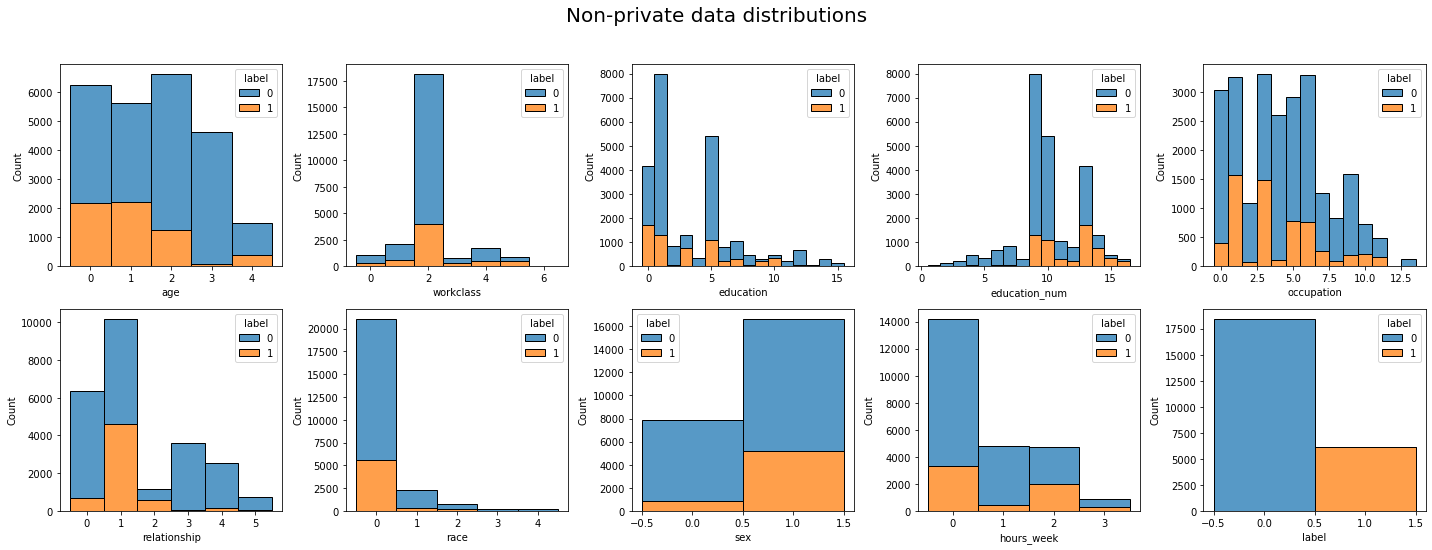

In [7]:
# Plot the non-private distributions
plot_distributions(cat_train, title="Non-private data distributions", savefig=True)

# 2. Train binary classifier on non-private data

In [8]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="logistic", dataset="adult")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.4416, Male: 0.6141

False positive rates:
Female: 0.0246, Male: 0.1159

Equalized odds distances:
y=1: 0.1725, y=0: 0.0913

Classification accuracies:
Female: 0.9144, Male: 0.7977

F1-score: 0.6443

Avg train pred: 0.2017, Avg test pred: 0.2085


In [9]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="forest", dataset="adult")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.4069, Male: 0.6027

False positive rates:
Female: 0.0402, Male: 0.1494

Equalized odds distances:
y=1: 0.1958, y=0: 0.1092

Classification accuracies:
Female: 0.8966, Male: 0.7713

F1-score: 0.6068

Avg train pred: 0.2301, Avg test pred: 0.2246


# 3. New MWEM synthesis

In [7]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", n_reps=10)

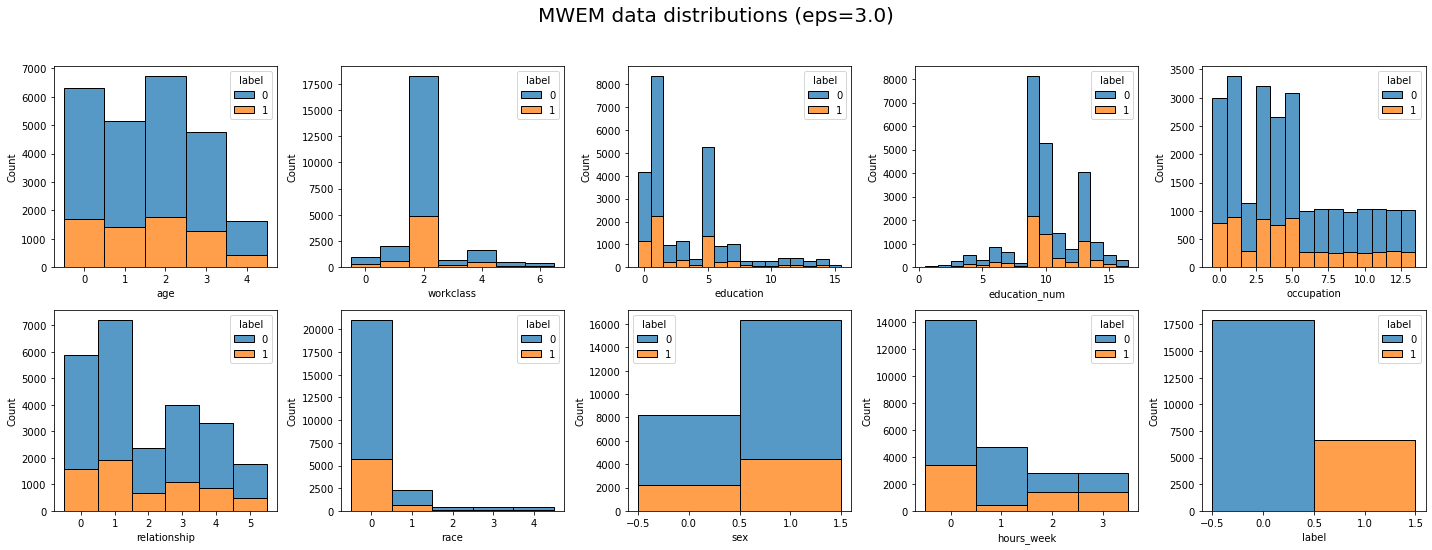

In [11]:
MWEM_eps3_rep0 = pd.read_csv("MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)")

In [12]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.067
FPR difference median: 0.046
F1-score median: 0.203


In [13]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.130
FPR difference median: 0.045
F1-score median: 0.285


# 4. New DP-CTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", n_reps=10)

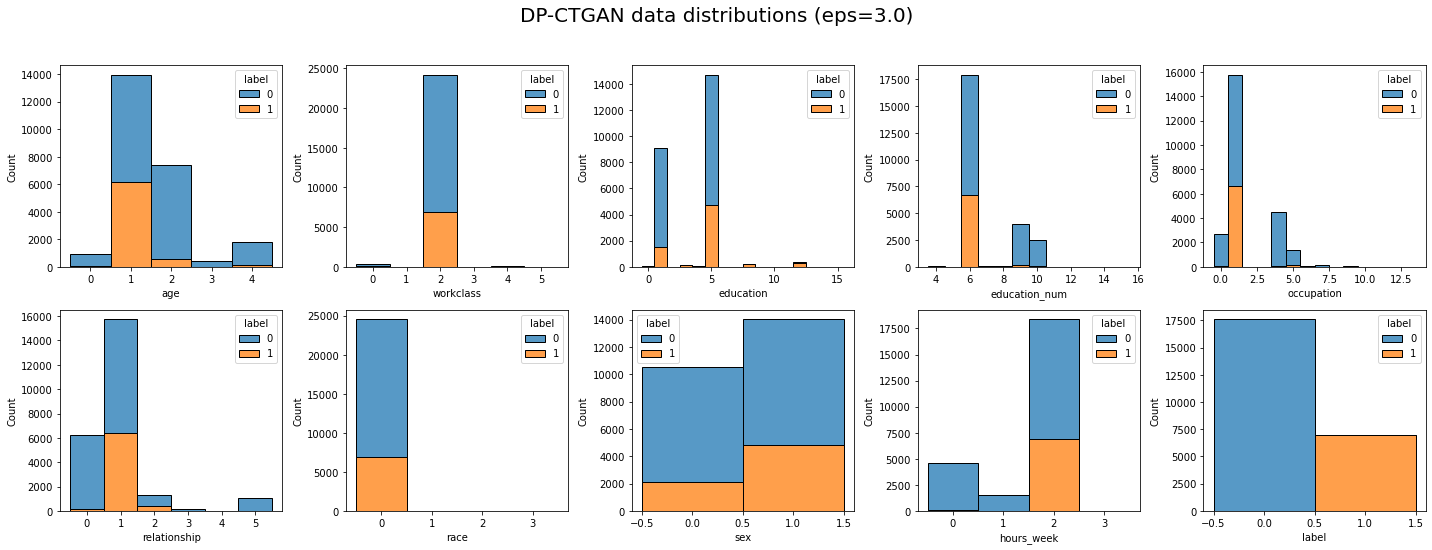

In [14]:
DPCTGAN_eps3_rep0 = pd.read_csv("DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)")

In [15]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.182
FPR difference median: 0.063
F1-score median: 0.502


In [16]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.261
FPR difference median: 0.094
F1-score median: 0.490


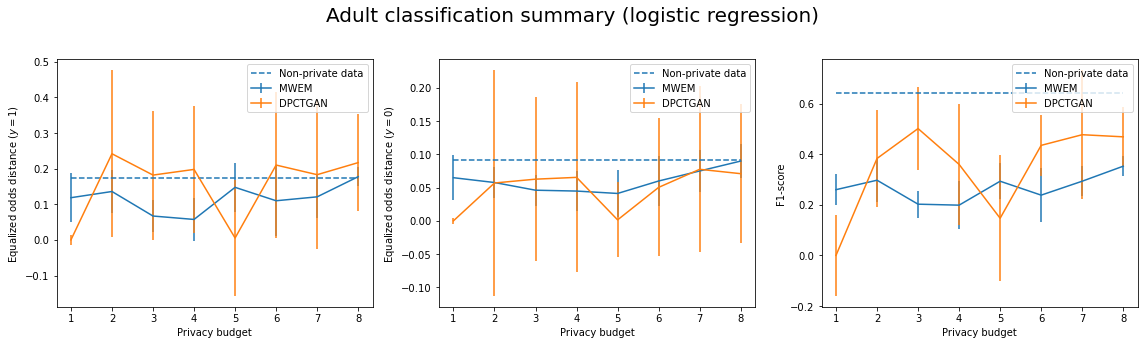

In [17]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult")

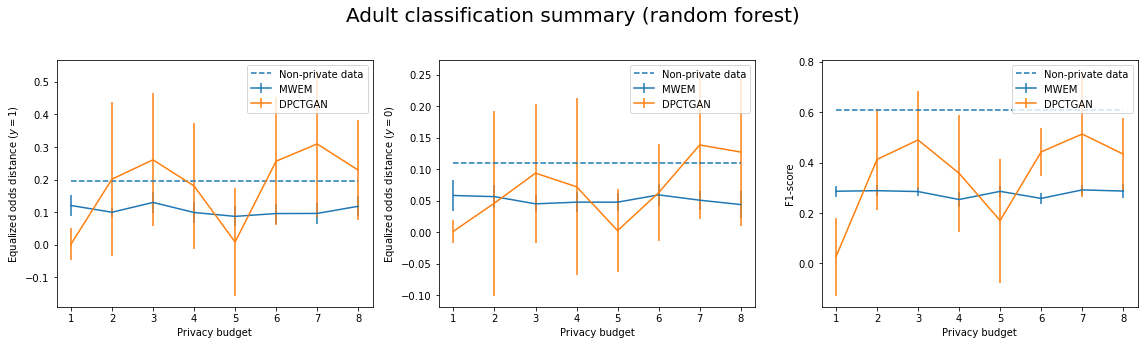

In [18]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult")

# 5. New PATE-CTGAN synthesis (tuning)

In [27]:
# Set range of epsilon values
epsilon_vals = [3.0]

In [28]:
# Generate 10 repetitions of synthetic data with PATECTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", n_reps=10, dataset="adult", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5)

Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.


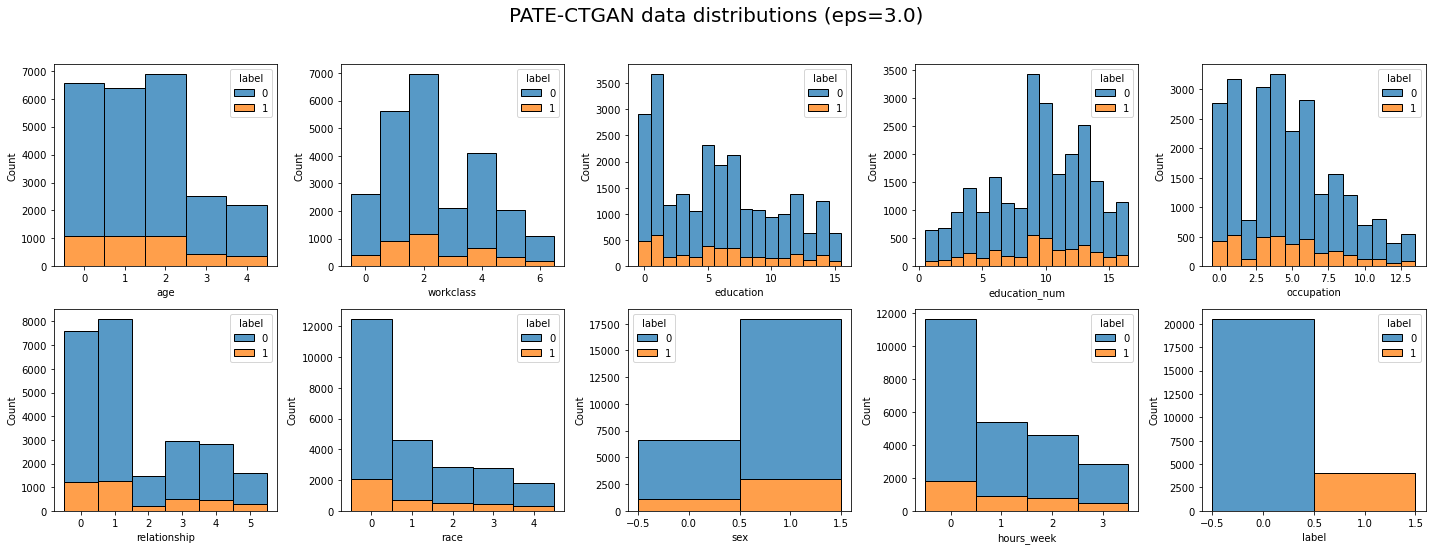

In [19]:
# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [21]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [23]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.008
FPR difference median: 0.007
F1-score median: 0.018


In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=200, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=64, generator_dim=(128,128), discriminator_dim=(128,128), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=32, generator_dim=(64,64), discriminator_dim=(64,64), batch_size=100, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

# 6. New QUAIL-MWEM synthesis

In [8]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10)

In [25]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.371
FPR difference median: 0.124
F1-score median: 0.481


In [26]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.393
FPR difference median: 0.120
F1-score median: 0.476


# 7. New QUAIL-DPCTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10)

In [27]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.308
FPR difference median: 0.082
F1-score median: 0.475


In [28]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.216
FPR difference median: 0.067
F1-score median: 0.462


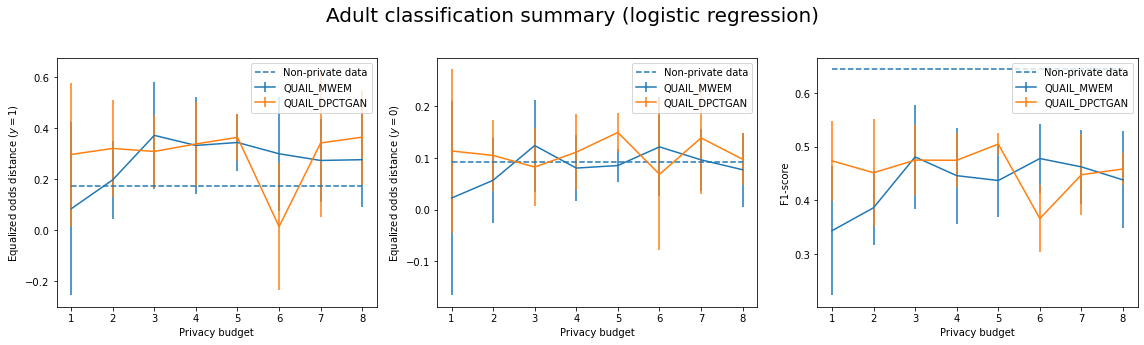

In [12]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult")

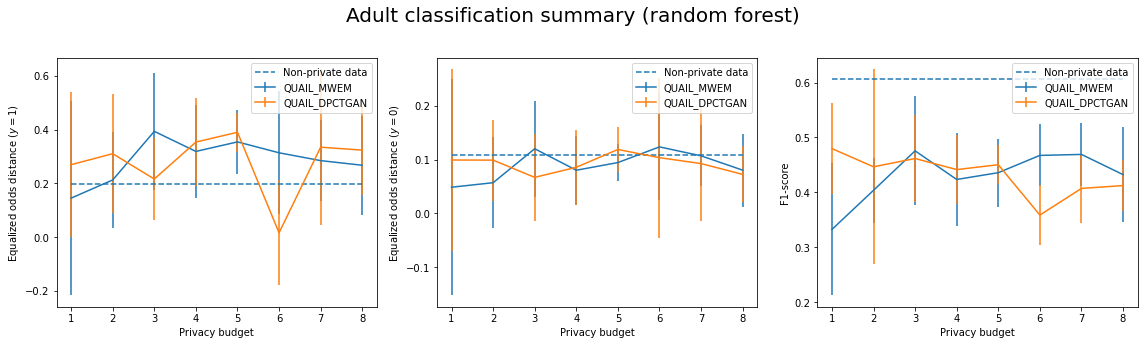

In [38]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult")

# 8. New QUAIL-PATECTGAN synthesis

In [29]:
# error: epsilon=1.0 too small?
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10)

In [31]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.291
FPR difference median: 0.097
F1-score median: 0.419


In [32]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.158
FPR difference median: 0.054
F1-score median: 0.306


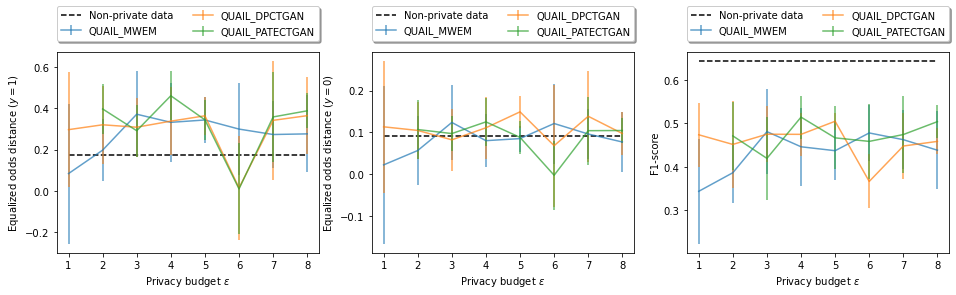

In [9]:
# Save results from all three synthesizers
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult", results_dir="adult/", savefig=True)

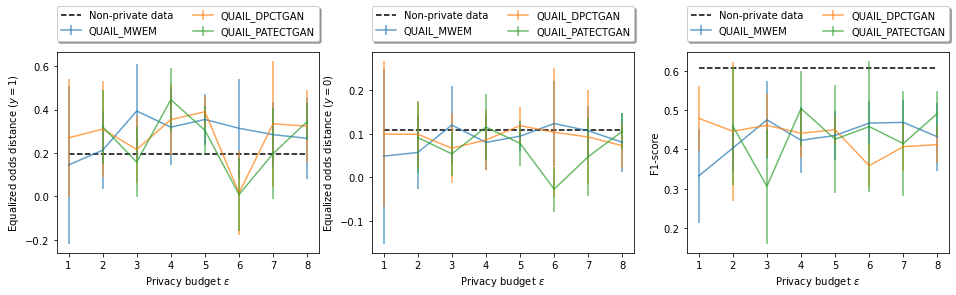

In [10]:
# Save results from all three synthesizers
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult", results_dir="adult/", savefig=True)

# 9. Comparison to DPLR

In [11]:
# Set range of epsilon values
epsilon_vals = [3.0]

# Calculate the median results
tpr_diff_median, fpr_diff_median, f1_score_median = get_dp_model_table_metrics(epsilon_vals, nreps=10, classifier="logistic", train_df=encoded_train, test_df=encoded_test, dataset="adult")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.164
FPR difference median: 0.096
F1-score median: 0.626


# 10. Comparison to k-anonymity

In [12]:
# Convert categorical data into format required by k-anonymization algo
str_cat_train = convert_to_str(cat_train)

In [13]:
# Get the spans of the categorical variables
full_spans = get_spans(str_cat_train, str_cat_train.index)

In [14]:
# Specify the feature columns and label
feature_columns = ["age", "workclass", "education", "education_num", "occupation",
                   "relationship", "race", "sex", "hours_week"]
sensitive_column = "label"

# Make partitions for k=3
finished_partitions = partition_dataset(str_cat_train, feature_columns, sensitive_column, full_spans, is_k_anonymous, k=5)

# Get the number of partitions created
len(finished_partitions)

2521

In [15]:
# Build anonymized data set
kanon_df = build_anonymized_dataset(str_cat_train, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...
Finished 1601 partitions...
Finished 1701 partitions...
Finished 1801 partitions...
Finished 1901 partitions...
Finished 2001 partitions...
Finished 2101 partitions...
Finished 2201 partitions...
Finished 2301 partitions...
Finished 2401 partitions...
Finished 2501 partitions...


In [16]:
# Drop rows with grouped categories
kanon_df = drop_grouped_rows(kanon_df)
kanon_df

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
0,1,2,1,3,9,2,2,0,1,0
1,1,2,1,3,9,2,2,0,1,1
6,1,3,7,1,6,0,3,0,2,0
8,3,3,1,9,0,4,1,0,0,0
9,2,3,1,9,0,0,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...
3940,2,2,7,1,1,1,0,1,0,1
3943,2,2,1,9,1,2,0,0,0,0
3944,2,2,1,9,1,2,0,0,0,1
3959,2,2,1,9,0,1,0,1,0,0


In [17]:
# One-hot encode the k-anonymized data
encoded_kanon = one_hot_encode(kanon_df, dataset="adult")

# Get classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="logistic", dataset="adult")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.2900, Male: 0.3912

False positive rates:
Female: 0.0268, Male: 0.0984

Equalized odds distances:
y=1: 0.1012, y=0: 0.0716

Classification accuracies:
Female: 0.8951, Male: 0.7383

F1-score: 0.4746

Avg train pred: 0.1752, Avg test pred: 0.1476


# 11. Pre-processing (undersampling before synth)

In [8]:
def multi_undersample(cat_df, protected_att, target):
    
    # Count the number of rows for each group and target label
    group0_counts = [len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)])]
    group1_counts = [len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)])]
    all_counts = group0_counts + group1_counts
    
    # Identify the minority count (w.r.t group and label)
    min_count_id = np.argmin(all_counts)
    min_count = all_counts[min_count_id]
    
    # Randomly drop rows from the same group and opposite label
    if min_count_id == 0:
        count_diff = all_counts[1] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 1:
        count_diff = all_counts[0] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 2:
        count_diff = all_counts[3] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)
    else:
        count_diff = all_counts[2] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)    
    
    return cat_df

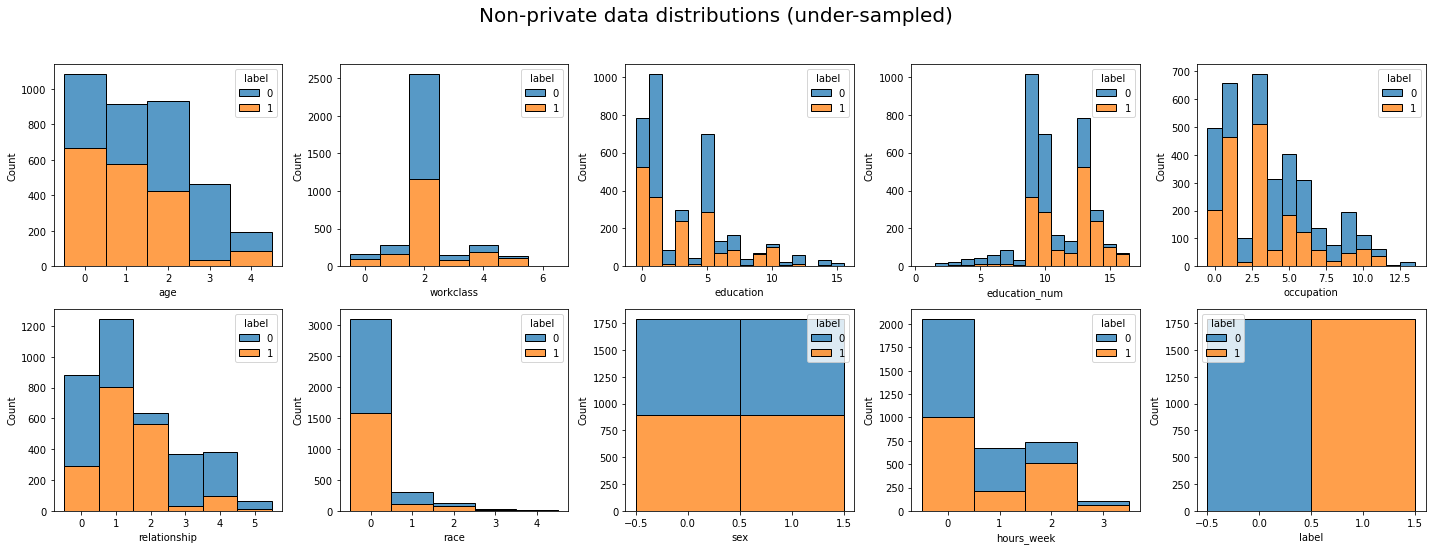

In [10]:
# Balance the groups and labels
multi_balanced = multi_undersample(cat_train, protected_att="sex", target="label")
plot_distributions(multi_balanced, title="Non-private data distributions (under-sampled)", savefig=True)

In [40]:
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, results_dir="preprocessed/")

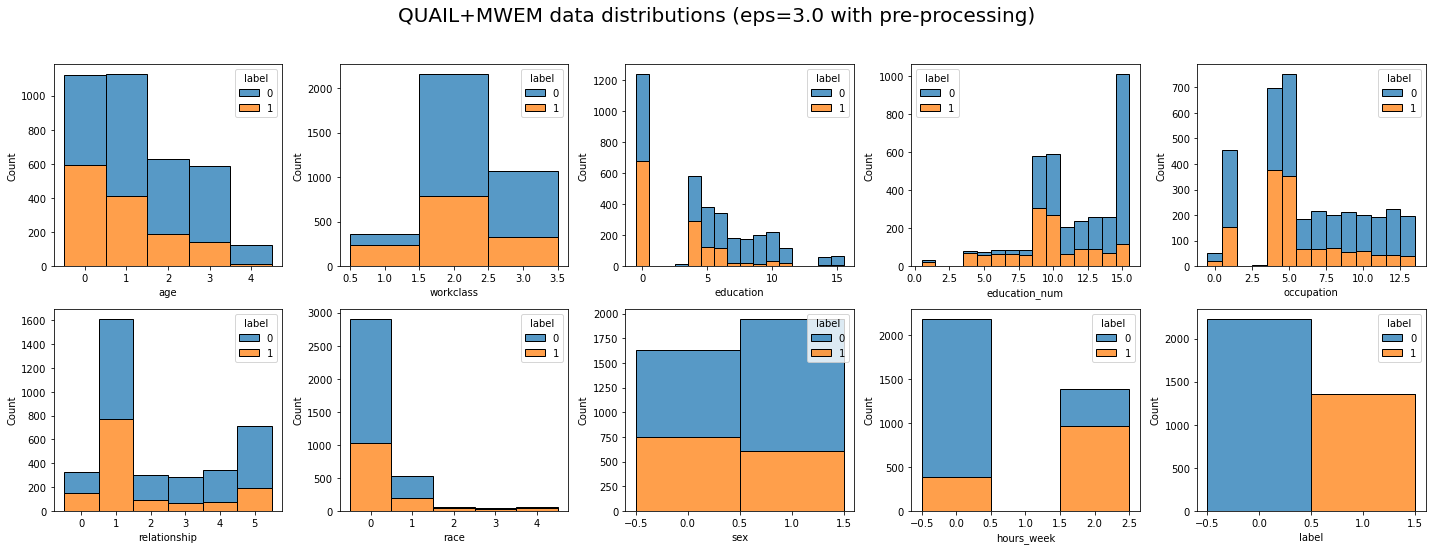

In [41]:
# Plot distributions of pre-processed synthetic data
QUAIL_MWEM_eps3_rep0 = pd.read_csv("preprocessed/QUAIL_MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(QUAIL_MWEM_eps3_rep0, title="QUAIL+MWEM data distributions (eps=3.0 with pre-processing)")

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, results_dir="preprocessed/")

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-PATECTGAN
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, results_dir="adult/preprocessed/")

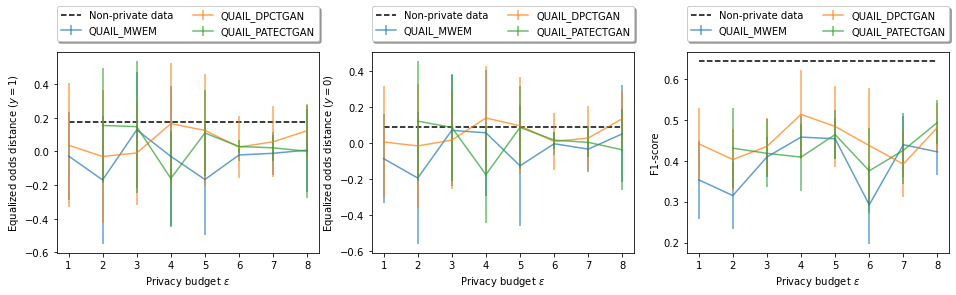

In [12]:
# Save results from all three synthesizers
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult", results_dir="adult/preprocessed/", savefig=True)

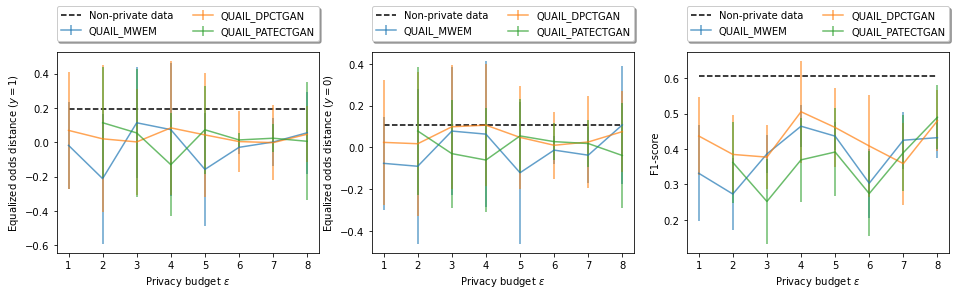

In [13]:
# Save results from all three synthesizers
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="adult", results_dir="adult/preprocessed/", savefig=True)

In [14]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult", results_dir="adult/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.128
FPR difference median: 0.070
F1-score median: 0.409


In [15]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult", results_dir="adult/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.009
FPR difference median: 0.016
F1-score median: 0.435


In [16]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="adult", results_dir="adult/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.147
FPR difference median: 0.086
F1-score median: 0.418
